# import

In [1]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

In [2]:
#freetoken="DEV-5fa1054cd25ed5a94ead77ab54c60e280f772f28"
#paidtoken="6HCl-4905ed959746710cfc6edae637828621490a45d7"

In [3]:
from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))


QPU Advantage2_prototype1.1 was selected.


In [4]:
#test if certain nodes are in the Zephyr graph
node_test = 72
node_test2 = -1
for link in sampler.edgelist:
    if node_test in link or node_test2 in link:
        print(link)

(72, 73)
(72, 76)
(72, 289)
(72, 292)
(72, 297)
(72, 300)
(72, 305)
(72, 313)
(72, 316)
(72, 321)
(72, 324)
(72, 329)
(72, 332)
(72, 337)
(72, 340)
(72, 345)
(72, 348)


In [5]:
#set a simulated annealer sampler
simsampler=dimod.SimulatedAnnealingSampler()

# functions

In [6]:
#define a function to turn lists of tuples (edges) into arrays
def TuptoArray(tuplist):
    list0=[]
    list1=[]
    for tup in tuplist:
        list0.append(tup[0])
        list1.append(tup[1])
    edgearray=np.array([list0,list1])
    return edgearray

In [7]:
#define functions to tile any hex or tri array to the right or down
def tile_right(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=64
            if qub in verticals:
                add_arr[i][j]=1   
    
    out_arr = inp_arr + add_arr
    return out_arr

def tile_left(inp_arr):
    sub_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                sub_arr[i][j]=64
            if qub in verticals:
                sub_arr[i][j]=1   
    
    out_arr = inp_arr - sub_arr
    return out_arr

def tile_down(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=1
            if qub in verticals:
                add_arr[i][j]=64   
    
    out_arr = inp_arr + add_arr
    return out_arr

In [8]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [9]:
#define a function to tile the base hexs and tris to the desired lattice size
def NxN_tile(N,fold):
    
    #initialize the registries with the base arrays
    hex1reg=[]
    hex1reg.append(hex1base)
    hex2reg=[]
    hex2reg.append(hex2base)
    tri1reg=[]
    tri1reg.append(tri1base)
    tri2reg=[]
    tri2reg.append(tri2base)
    tri3reg=[]
    tri3reg.append(tri3base)
    tri4reg=[]
    tri4reg.append(tri4base)
    
    if fold==True:
        hex3reg=[]
        hex3reg.append(hex3base)
        hex4reg=[]
        hex4reg.append(hex4base)
        hex5reg=[]
        hex5reg.append(hex5base)
        tri5reg=[]
        tri5reg.append(tri5base)
        tri6reg=[]
        tri6reg.append(tri6base)
        tri7reg=[]
        tri7reg.append(tri7base)
        tri8reg=[]
        tri8reg.append(tri8base)
        tri9reg=[]
        tri9reg.append(tri9base)
    
    #tile layer 1 to the right, tile layer 2 to the left
    for i in range(N-1):
        hex1reg.append(tile_right(hex1reg[i]))
        hex2reg.append(tile_right(hex2reg[i]))
        tri1reg.append(tile_right(tri1reg[i]))
        tri2reg.append(tile_right(tri2reg[i]))
        tri3reg.append(tile_right(tri3reg[i]))
        tri4reg.append(tile_right(tri4reg[i]))
        if fold==True:
            hex4reg.append(tile_left(hex4reg[i]))
            tri6reg.append(tile_left(tri6reg[i]))
            tri7reg.append(tile_left(tri7reg[i]))
            tri8reg.append(tile_left(tri8reg[i]))
    for i in range(N-2):    
        if fold==True:
            hex5reg.append(tile_left(hex5reg[i]))
            tri9reg.append(tile_left(tri9reg[i]))
        
    #now every registry has the first row of hexs or tris
    hex1row=hex1reg
    hex2row=hex2reg
    tri1row=tri1reg
    tri2row=tri2reg
    tri3row=tri3reg
    tri4row=tri4reg
    if fold==True:
        hex3row=hex3reg
        hex4row=hex4reg
        hex5row=hex5reg
        tri5row=tri5reg
        tri6row=tri6reg
        tri7row=tri7reg
        tri8row=tri8reg
        tri9row=tri9reg

    for i in range(N-1):
        newrowhex1=[]
        for j in range(len(hex1row)):
            hex1reg.append(tile_down(hex1row[j]))
            newrowhex1.append(tile_down(hex1row[j]))
        hex1row=newrowhex1
        
        if fold==True:
            newrowhex3=[]
            for j in range(len(hex3row)):
                hex3reg.append(tile_down(hex3row[j]))
                newrowhex3.append(tile_down(hex3row[j]))
            hex3row=newrowhex3
            newrowhex5=[]
            for j in range(len(hex5row)):
                hex5reg.append(tile_down(hex5row[j]))
                newrowhex5.append(tile_down(hex5row[j]))
            hex5row=newrowhex5
            
        newrowtri1=[]
        for j in range(len(tri1row)):
            tri1reg.append(tile_down(tri1row[j]))
            newrowtri1.append(tile_down(tri1row[j]))
        tri1row=newrowtri1
        newrowtri2=[]
        for j in range(len(tri2row)):
            tri2reg.append(tile_down(tri2row[j]))
            newrowtri2.append(tile_down(tri2row[j]))
        tri2row=newrowtri2
        
        if fold==True:
            newrowtri7=[]
            for j in range(len(tri7row)):
                tri7reg.append(tile_down(tri7row[j]))
                newrowtri7.append(tile_down(tri7row[j]))
            tri7row=newrowtri7
            newrowtri8=[]
            for j in range(len(tri8row)):
                tri8reg.append(tile_down(tri8row[j]))
                newrowtri8.append(tile_down(tri8row[j]))
            tri8row=newrowtri8
        
    for i in range(N-2):
        newrowhex2=[]
        for j in range(len(hex2row)):
            hex2reg.append(tile_down(hex2row[j]))
            newrowhex2.append(tile_down(hex2row[j]))
        hex2row=newrowhex2
        
        if fold==True:
            newrowhex4=[]
            for j in range(len(hex4row)):
                hex4reg.append(tile_down(hex4row[j]))
                newrowhex4.append(tile_down(hex4row[j]))
            hex4row=newrowhex4
            
        newrowtri3=[]
        for j in range(len(tri3row)):
            tri3reg.append(tile_down(tri3row[j]))
            newrowtri3.append(tile_down(tri3row[j]))
        tri3row=newrowtri3
        newrowtri4=[]
        for j in range(len(tri4row)):
            tri4reg.append(tile_down(tri4row[j]))
            newrowtri4.append(tile_down(tri4row[j]))
        tri4row=newrowtri4
        
        if fold==True:
            newrowtri5=[]
            for j in range(len(tri5row)):
                tri5reg.append(tile_down(tri5row[j]))
                newrowtri5.append(tile_down(tri5row[j]))
            tri5row=newrowtri5
            newrowtri6=[]
            for j in range(len(tri6row)):
                tri6reg.append(tile_down(tri6row[j]))
                newrowtri6.append(tile_down(tri6row[j]))
            tri6row=newrowtri6
            newrowtri9=[]
            for j in range(len(tri9row)):
                tri9reg.append(tile_down(tri9row[j]))
                newrowtri9.append(tile_down(tri9row[j]))
            tri9row=newrowtri9
            
    if fold==False:
        hex3reg=[]
        hex4reg=[]
        hex5reg=[]
        tri5reg=[]
        tri6reg=[]
        tri7reg=[]
        tri8reg=[]
        tri9reg=[]
        
    return hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg

In [10]:
def RegsToTups(all_regs):
    alledges=[]
    allnodes=[]
    for arr in all_regs:
        list0=arr[0]
        list1=arr[1]
        for i in range(len(list0)):
            qubit0=int(list0[i])
            qubit1=int(list1[i])
            alledges.append((qubit0,qubit1))
            allnodes.append(qubit0)
            allnodes.append(qubit1)
    allnodes=set(allnodes)
    return alledges,allnodes

In [11]:
def magnetization(response):
    mags=[]
    for i in range(len(response.lowest().record)):
        run_pms=response.record[i][0]
        mags.append(np.mean(run_pms))

    avgmag=np.mean(mags)

    return mags,avgmag

In [12]:
# function to fill in missing couplers by using another coupler
def find_intersection(missedge,allnodes,missingcoups,missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = missedge[0]
    q1m = missedge[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        if q0m in missingqs:
            print(q0m, "missing")
            missingqubit=q0m
        if q1m in missingqs:
            missingqubit=q1m
            print(q1m, "missing")
        
        
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)
            
    q0mcoups = set(q0mcoups)
    q1mcoups = set(q1mcoups)

    #find the intersection
    intersection = q0mcoups.intersection(q1mcoups)
    intersection = list(intersection)
        
    #for every intersection qubit, check if it is already in use in the embedding
    #if no good intersection exists, the missing coupler is unresolved
    if len(intersection) != 0:
        goodinter=[]
        for inter in intersection:
            if inter not in allnodes:
                goodinter.append(inter)
        if len(goodinter)==0:
            unresolved=True
        else:
            unresolved=False
    else:
        unresolved=True
        

    return intersection,goodinter,unresolved


In [13]:
def resolve_unresolved(unres, allnodes, missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = unres[0]
    q1m = unres[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        print("one or more of the qubits in this coupler are missing")
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)

    q0mcontigs = list(set(q0mcoups))
    q1mcontigs = list(set(q1mcoups))

#     print(q0mcontigs)
#     print(q1mcontigs)

    candidates = []
    for q0 in q0mcontigs:
        for q1 in q1mcontigs:
            if (((q0, q1) in sampler.edgelist or Reverse(
                (q0, q1)) in sampler.edgelist)
                    and (q0 not in allnodes and q1 not in allnodes)):
                candidates.append((q0, q1))

    for cand in candidates:

        two_2chains = [(q0m, cand[0]), (q1m, cand[1])]
        verified_2chains = []
        for chain in two_2chains:
            if chain in sampler.edgelist:
                verified_2chains.append(chain)
            else:
                if Reverse(chain) in sampler.edgelist:
                    verified_2chains.append(Reverse(chain))

            if (len(verified_2chains) == 2
                    and (cand in sampler.edgelist
                         or Reverse(cand) in sampler.edgelist)):
                finalafm = cand
                final_2chains = verified_2chains
                break

    return finalafm, final_2chains

In [14]:
def check_nodes(nodes):
    missingqubits = []
    for node in nodes:
        if node not in sampler.nodelist:
            missingqubits.append(node)
    return missingqubits

In [15]:
def check_edges(edges):
    missingedges=[]
    for edge in edges:
        if edge not in sampler.edgelist and Reverse(edge) not in sampler.edgelist:
            missingedges.append(edge)
    return missingedges

In [16]:
def remove_tup_repeats(edges):
    edges_norepeats=[]
    for edge in edges:
        if (edge not in edges_norepeats and Reverse(edge) not in edges_norepeats):
            edges_norepeats.append(edge)
    return edges_norepeats

In [17]:
def DocName(jafm,k2,h1,h2,s):
    
    str1="J="+str(jafm)
    str2="h1,h2,k2,s="+str(h1)+","+str(h2)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

In [18]:
def set_jkhs(jafm, k2, h1, s):

    h2 = h1 / 2

    #make an array of these values
    paramsarray = np.array([['jafm', 'k2', 'h1', 'h2', 's'],
                            [jafm, k2, h1, h2, s]])

    return paramsarray

In [19]:
def checks(alledges,allnodes):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first

    ### for now let's just remove the couplers associated with the missing qubits
    missingqcoups=[]
    for missingq in missingqs:
        for coup in missingcoups:
            if (coup[0]==missingq or coup[1]==missingq):
                missingqcoups.append(coup)
#     print("coups associated with missing qubits",missingqcoups)
    for coup in missingqcoups:
#         print("removing",coup)
        missingcoups.remove(coup)
        edges_norepeats.remove(coup)


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        final_coups.update({edge:jafm})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

In [20]:
def set_hs(final_nodes,onechain_nodes,twochain_nodes,h1,h2):
    hdict={}
    for node in final_nodes:
        if node in onechain_nodes:
            hdict.update({node:h1})
        if node in twochain_nodes:
            hdict.update({node:h2})
        if (node in onechain_nodes and node in twochain_nodes):
            print("error")
    return hdict

In [21]:
def classify_Js(final_coups,twochains,twochain_nodes,onechain_nodes):
    
    J11coups=[]
    J22coups=[]
    J12coups=[]
    
    for coup in final_coups:
        if (coup not in twochains and Reverse(coup) not in twochains):
            q0=coup[0]
            q1=coup[1]
            if (q0 in twochain_nodes and q1 in twochain_nodes):
                J22coups.append(coup)
#                 print(coup,"a J22")
            elif (q0 in onechain_nodes and q1 in onechain_nodes):
                J11coups.append(coup)
#                 print(coup,"a J11")
            elif ((q0 in twochain_nodes) ^ (q1 in twochain_nodes)):
                J12coups.append(coup)
#                 print(coup,"a J12")
            else:
                print("ERROR",coup)
            
    return J11coups, J22coups, J12coups

# base hexs and tris

In [22]:
#which qubits are vertical qubits (lying on a vertical line) and which are horizontal?
#this is important for the naming convention
horizontals=[*range(288)]
verticals=[*range(288,575)]

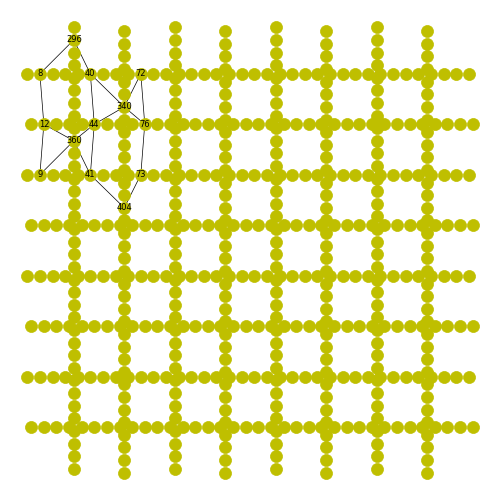

In [23]:
#this is layer 1
#define the 2 base hexagons and the 4 base triangles
hex1nodes=[296,40,44,360,12,8]
hex2nodes=[340,76,73,404,41,44]
hex1edges=[]
hex2edges=[]

for i in range(len(hex1nodes)):
    if i<len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[i+1]))
    if i==len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[0]))
        
for i in range(len(hex2nodes)):
    if i<len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[i+1]))
    if i==len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[0]))
    
tri1edges=[(40,340),(340,44),(44,40)]
tri2edges=[(72,76),(76,340),(340,72)]
tri3edges=[(44,41),(41,360),(360,44)]
tri4edges=[(12,360),(360,9),(9,12)]

hextriedges=hex1edges+hex2edges+tri1edges+tri2edges+tri3edges+tri4edges
hextriedges=list(set(hextriedges))

hextrinodes=[]
for tup in hextriedges:
    hextrinodes.append(tup[0])
    hextrinodes.append(tup[1])
hextrinodes=list(set(hextrinodes))

hextrilabels={}
for node in hextrinodes:
    hextrilabels.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges)
dnx.draw_zephyr(Kag,labels=hextrilabels,node_color='y')
plt.show()

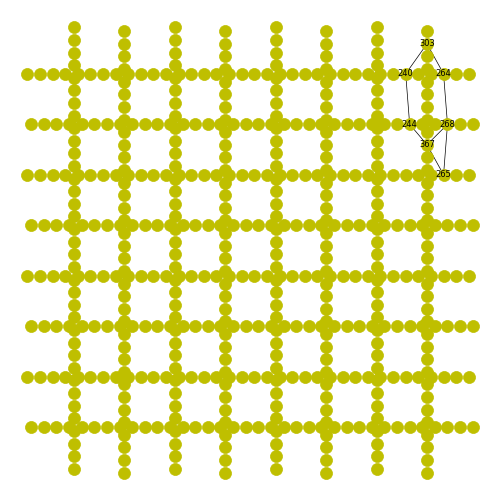

In [24]:
#this is the connection between layer 1 and layer 2
#define the 1 base hexagon and the 1 base triangle
hex3nodes=[303,240,244,367,268,264]
hex3edges=[]

for i in range(len(hex3nodes)):
    if i<len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[i+1]))
    if i==len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[0]))
    
tri5edges=[(268,367),(367,265),(265,268)]

#"con" denotes connection
hextriedges_con=hex3edges+tri5edges
hextriedges_con=list(set(hextriedges_con))

hextrinodes_con=[]
for tup in hextriedges_con:
    hextrinodes_con.append(tup[0])
    hextrinodes_con.append(tup[1])
hextrinodes_con=list(set(hextrinodes_con))

hextrilabels_con={}
for node in hextrinodes_con:
    hextrilabels_con.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges_con)
dnx.draw_zephyr(Kag,labels=hextrilabels_con,node_color='y')
plt.show()

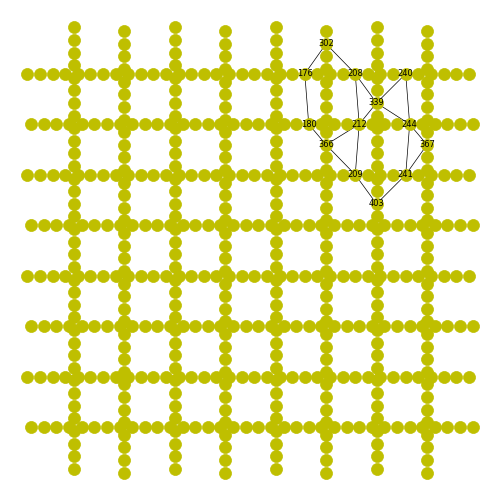

In [25]:
#this is layer 2
#define the 2 base hexagons and the 4 base triangles
hex4nodes=[339,212,209,403,241,244]
hex5nodes=[302,176,180,366,212,208]
hex4edges=[]
hex5edges=[]

for i in range(len(hex4nodes)):
    if i<len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[i+1]))
    if i==len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[0]))
        
for i in range(len(hex5nodes)):
    if i<len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[i+1]))
    if i==len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[0]))

tri6edges=[(244,241),(241,367),(367,244)]        
tri7edges=[(240,339),(339,244),(244,240)]
tri8edges=[(208,339),(339,212),(212,208)]
tri9edges=[(212,366),(366,209),(209,212)]

hextriedges2=hex4edges+hex5edges+tri6edges+tri7edges+tri8edges+tri9edges
hextriedges2=list(set(hextriedges2))

hextrinodes2=[]
for tup in hextriedges2:
    hextrinodes2.append(tup[0])
    hextrinodes2.append(tup[1])
hextrinodes2=list(set(hextrinodes2))

hextrilabels2={}
for node in hextrinodes2:
    hextrilabels2.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges2)
dnx.draw_zephyr(Kag,labels=hextrilabels2,node_color='y')
plt.show()

In [26]:
#redefine the base hexs and tris as arrays
hex1base = TuptoArray(hex1edges)
hex2base = TuptoArray(hex2edges)
hex3base = TuptoArray(hex3edges)
hex4base = TuptoArray(hex4edges)
hex5base = TuptoArray(hex5edges)
tri1base = TuptoArray(tri1edges)
tri2base = TuptoArray(tri2edges)
tri3base = TuptoArray(tri3edges)
tri4base = TuptoArray(tri4edges)
tri5base = TuptoArray(tri5edges)
tri6base = TuptoArray(tri6edges)
tri7base = TuptoArray(tri7edges)
tri8base = TuptoArray(tri8edges)
tri9base = TuptoArray(tri9edges)
#now we have a bunch of arrays that we can add to to create a larger lattice

# regs, embedding drawing

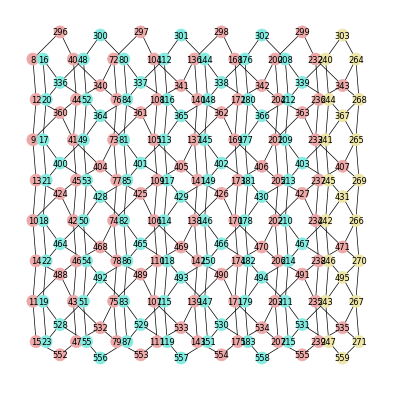

In [27]:
hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg=NxN_tile(N=4,fold=True)

allhexreg=np.array([hex1reg,hex2reg,hex3reg,hex4reg,hex5reg],dtype=object)
alltrireg=np.array([tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg],dtype=object)

layer1regs=hex1reg+hex2reg+tri1reg+tri2reg+tri3reg+tri4reg
connectionregs=hex3reg+tri5reg
layer2regs=hex4reg+hex5reg+tri6reg+tri7reg+tri8reg+tri9reg
allregs=layer1regs+connectionregs+layer2regs

layer1edges,layer1nodes=RegsToTups(layer1regs)
connectionedges,connectionnodes=RegsToTups(connectionregs)
layer2edges,layer2nodes=RegsToTups(layer2regs)
alledges,allnodes=RegsToTups(allregs)

layer1nodes=list(set(layer1nodes))
layer2nodes=list(set(layer2nodes))
connectionnodes=list(set(connectionnodes))

plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=50

alllabels={}
for node in allnodes:
    alllabels.update({node:str(node)})

Zeph=dnx.zephyr_graph(4)
Kagall=dnx.zephyr_graph(4,edge_list=alledges)
Kag1=dnx.zephyr_graph(4,edge_list=layer1edges)
Kag2=dnx.zephyr_graph(4,edge_list=layer2edges)
Kagcon=dnx.zephyr_graph(4,edge_list=connectionedges)
Kag2andcon=dnx.zephyr_graph(4,edge_list=connectionedges+layer2edges)

allcolors=[]
for node in Kagall.nodes():
    if (node in layer1nodes and node in connectionnodes and node in layer2nodes):
        allcolors.append('#ede6a8')
    elif (node in layer1nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    elif (node in layer2nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    else:
        if node in layer1nodes:
            allcolors.append('#eda8a8')
        elif node in layer2nodes:
            allcolors.append('#83ebe0')
        elif node in connectionnodes:
            allcolors.append('#ede6a8')
        else:
            allcolors.append('none')

#allcolors=np.array([sorted(allnodes),allcolors])

#removing nodes and adding other edges for periodic boundary conditions
#Kagall.remove_node(8)
#Kagall.add_edge(*[296,16])
    
dnx.draw_zephyr(
    Kagall,
    #node_color = 'none'
    node_color=allcolors,
    labels=alllabels,
)
all_edges = np.array(Kagall.edges)
#dnx.draw_zephyr(Zeph)
#dnx.draw_zephyr(Kag1,node_color='#eda8a8',with_labels=True)
#dnx.draw_zephyr(Kag2,node_color='b',with_labels=True)
#dnx.draw_zephyr(Kag2andcon,node_color='#83ebe0',with_labels=True)
# plt.savefig('folded_kagome')
plt.show()

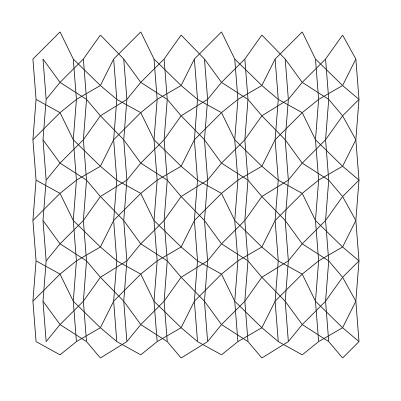

In [28]:
dnx.draw_zephyr(
    Kagall, node_color = 'none'
)

In [29]:
len(Kagall.edges)

375

# mapping the Zephyr kagome to real space

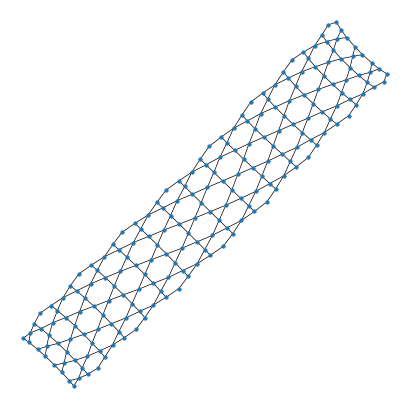

In [59]:
simplify_Kag_graph = nx.Graph()
big_graph = Kagall
all_edges_kag = [e for e in big_graph.edges()]
all_nodes_kag = []
for m in range(len(big_graph.nodes)):
    edges_to_it = big_graph.edges(m)
    if len(edges_to_it) > 0:
        all_nodes_kag.append(m)
        simplify_Kag_graph.add_node(m)
for e in all_edges_kag:
    simplify_Kag_graph.add_edge(*e)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
test, planar_embed = nx.check_planarity(simplify_Kag_graph)
pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
nx.draw(simplify_Kag_graph, pos, node_size = 25)


In [62]:
all_nodes_kag

[8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 424,
 425,
 426,
 427,
 428,
 429,
 430,


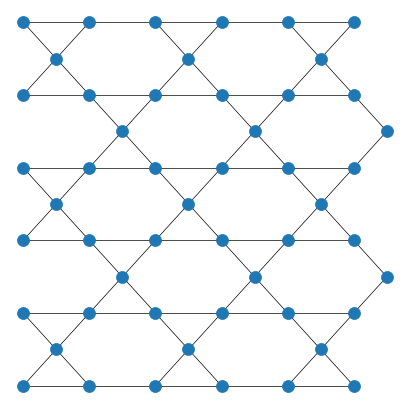

In [31]:
# a kagome graph with the positions. start with a triangular graph
#make a triangular lattice:
N=10
g_trig = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
g_kag = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
complement_graph = nx.Graph()
pos={}
pos_triangle = {}
for node in g_trig.nodes:
    pos_triangle.update({node:np.array(node)})
    if node[0] % 2 == 1 and node[1] % 4 == 1:
        g_kag.remove_node(node)
    elif node[0] % 2 == 0 and node[1] % 4 == 3:
        g_kag.remove_node(node)
    else:  
        #pos_here = np.array(node)  
        pos_here = np.array([1,np.sqrt(3)/2])*(np.array(node) + np.array([0.5, 0])*(node[1] % 2))
        pos.update({node:pos_here})
nx.draw(g_kag, pos)
#nx.draw(g_trig, pos_triangle)

In [32]:
g_trig.nodes

NodeView(((0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)))

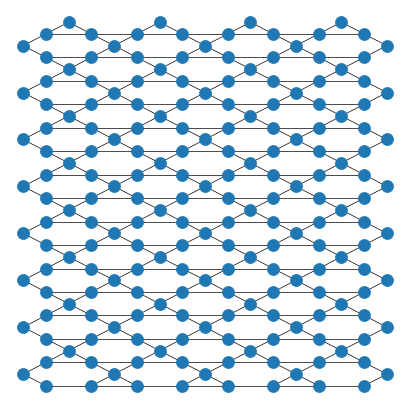

In [36]:
# a kagome graph with the positions. start with a triangular graph
#make a triangular lattice:
N=40
g_trig = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
g_kag = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
complement_graph = nx.Graph()
pos={}
frac = 0.1
for node in g_trig.nodes:
    if node[0] % 2 == 1 and node[1] % 4 == 1:
        g_kag.remove_node(node)
    elif node[0] % 2 == 0 and node[1] % 4 == 3:
        g_kag.remove_node(node)
    else:    
        pos_here = np.array([1,np.sqrt(3)/2])*(np.array(node) + np.array([0.5, 0])*(node[1] % 2))
        pos.update({node:pos_here})

#here, pos has the positions on the 2D array for a Kagome lattice

#new mapping of nodes as integers
pos2 = {}
i = 0
DictRelabel = {}
for node in g_kag.nodes:
    DictRelabel.update({node:i})
    pos2.update({i:pos[node]})
    i += 1

g_kag2 = nx.relabel_nodes(g_kag, DictRelabel)

#cut some x and y boundaries for what we think is the correct graph

ymax = 16.1 #for only Kag1
ymax = 32.1 #for Kagall
#second pass:
filter_graph = g_kag2.copy()
for node in g_kag2.nodes:
    xval = pos2[node][0]
    yval = pos2[node][1]
    if xval < 0.4:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif xval > 8.6:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif yval > ymax*np.sqrt(3)/2:
        filter_graph.remove_node(node)
        pos2.pop(node)

nx.draw(filter_graph, pos2)

for periodic lattice

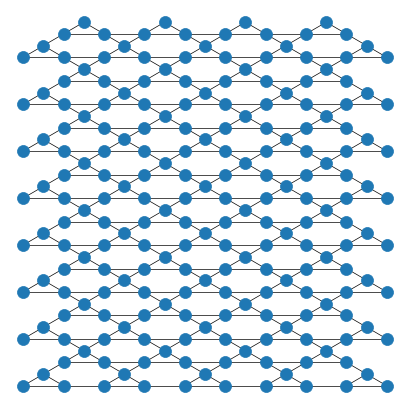

In [58]:
# a kagome graph with the positions. start with a triangular graph
#make a triangular lattice:
N=40
g_trig = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
g_kag = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
complement_graph = nx.Graph()
pos={}
frac = 0.1
for node in g_trig.nodes:
    if node[0] % 2 == 1 and node[1] % 4 == 1:
        g_kag.remove_node(node)
    elif node[0] % 2 == 0 and node[1] % 4 == 3:
        g_kag.remove_node(node)
    else:    
        pos_here = np.array([1,np.sqrt(3)/2])*(np.array(node) + np.array([0.5, 0])*(node[1] % 2))
        pos.update({node:pos_here})

#here, pos has the positions on the 2D array for a Kagome lattice

#new mapping of nodes as integers
pos2 = {}
i = 0
DictRelabel = {}
for node in g_kag.nodes:
    DictRelabel.update({node:i})
    pos2.update({i:pos[node]})
    i += 1

g_kag2 = nx.relabel_nodes(g_kag, DictRelabel)

#cut some x and y boundaries for what we think is the correct graph

ymax = 16.1 #for only Kag1
ymax = 32.1 #for Kagall
#second pass:
filter_graph = g_kag2.copy()
for node in g_kag2.nodes:
    xval = pos2[node][0]
    yval = pos2[node][1]
    #if yval % (4*np.sqrt(3)/2) != 0:

    if xval < 0.0:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif xval > 9:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif yval > ymax*np.sqrt(3)/2 - 0.2:
        filter_graph.remove_node(node)
        pos2.pop(node)

filter_graph2 = filter_graph.copy()
if True:
    for node in filter_graph.nodes:
        xval = pos2[node][0]
        yval = pos2[node][1]
        if abs(yval/(np.sqrt(3)/2) % 4) > 0.1:
            if xval < 0.4:
                filter_graph2.remove_node(node)
                pos2.pop(node)
            elif xval > 8.6:
                filter_graph2.remove_node(node)
                pos2.pop(node)


nx.draw(filter_graph2, pos2)

In [44]:
#compare the Zephyr graph (simplify_Kag_graph) with a filtered version that we have curated
GM = nx.isomorphism.GraphMatcher(simplify_Kag_graph, filter_graph)
print(GM.is_isomorphic())
mapping_dict = GM.mapping

True


In [45]:
#get the dictionary
final_qubit_dictionary = {}
for qubit in mapping_dict.keys():
    position = pos2[mapping_dict[qubit]]
    final_qubit_dictionary.update({qubit:position})


In [46]:
#output the dictionary which gives a real space position for the qubits on the D-Wave machine.
final_qubit_dictionary

{8: array([1., 0.]),
 12: array([2., 0.]),
 9: array([3., 0.]),
 13: array([4., 0.]),
 10: array([5., 0.]),
 14: array([6., 0.]),
 11: array([7., 0.]),
 15: array([8., 0.]),
 296: array([0.5      , 0.8660254]),
 360: array([2.5      , 0.8660254]),
 424: array([4.5      , 0.8660254]),
 488: array([6.5      , 0.8660254]),
 552: array([8.5      , 0.8660254]),
 40: array([1.        , 1.73205081]),
 44: array([2.        , 1.73205081]),
 41: array([3.        , 1.73205081]),
 45: array([4.        , 1.73205081]),
 42: array([5.        , 1.73205081]),
 46: array([6.        , 1.73205081]),
 43: array([7.        , 1.73205081]),
 47: array([8.        , 1.73205081]),
 340: array([1.5       , 2.59807621]),
 404: array([3.5       , 2.59807621]),
 468: array([5.5       , 2.59807621]),
 532: array([7.5       , 2.59807621]),
 72: array([1.        , 3.46410162]),
 76: array([2.        , 3.46410162]),
 73: array([3.        , 3.46410162]),
 77: array([4.        , 3.46410162]),
 74: array([5.        , 3.464

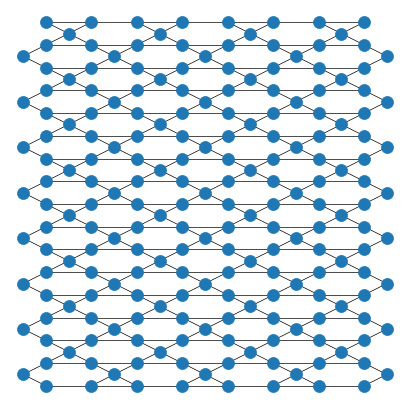

In [47]:
#show that, under this qubit dictionary, one recovers the Kagome graph! Hurra!
nx.draw(simplify_Kag_graph, final_qubit_dictionary)

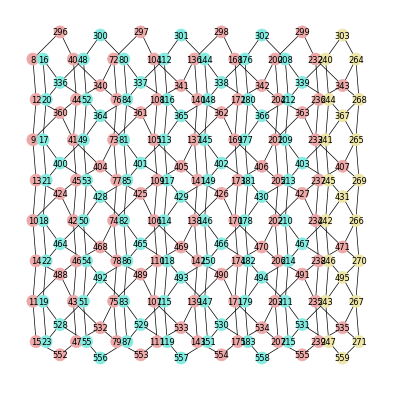

In [48]:
#show the zephyr drawing for consideration
dnx.draw_zephyr(
    Kagall,
    node_color=allcolors,
    labels=alllabels,
)

In [49]:
#check the unit distance between nodes
r1 = np.array([1,0])
r2 = np.array([0.5      , 0.8660254])
r3 = np.array([1.        , 1.73205081])
r4 = np.array([1.5       , 2.59807621])
np.linalg.norm(r3 - r4)

0.9999999967225798

In [89]:
#saving the dict and graph for future use.

import pickle

np.save("./data/dict_qbit_to_lattice.npy", final_qubit_dictionary)

#add the graph itself
pickle.dump(simplify_Kag_graph, open('./data/Kag_graph.pickle', 'wb'))


# Plotting a given lattice

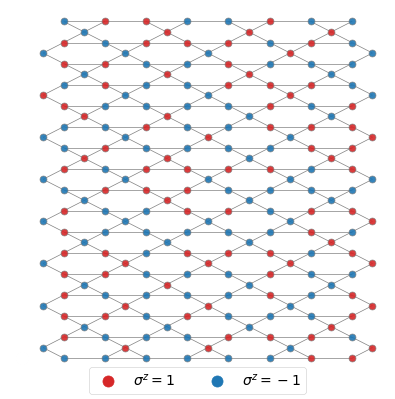

In [82]:
#plot the Kagome lattice graph with a certain response in mind

#--- 1 -- 
#make a generic response
test_array = np.ones(len(final_qubit_dictionary))
fm_to_disorder = 1.0
for i in range(len(test_array)):
    if np.random.rand() < fm_to_disorder:
        test_array[i] = 2*np.random.randint(2) - 1

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
qubits_val = [[], []]
for i in range(len(final_qubit_dictionary)):
    if test_array[i] == 1.0:
        qubits_val[0].append(test_response_qubits[i])
    if test_array[i] == -1.0:
        qubits_val[1].append(test_response_qubits[i])

#draw the graph with the specific nodes in red or blue

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "tab:red", r'$\sigma^z = -1$' : "tab:blue"}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[0],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [0], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
nx.draw_networkx_nodes(simplify_Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)

# edges
nx.draw_networkx_edges(simplify_Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,-0.07),loc='lower center', ncol=2, fontsize = 20)

plt.tight_layout()
plt.axis("off")
plt.show()

# structure factor

1. get k-space grid for kagome in reciprocal space
2. get S(q) - complex values in the k-space grid.

In [ ]:
test_array = np.ones(len(final_qubit_dictionary))
fm_to_disorder = 0.2
for i in range(len(test_array)):
    if np.random.rand() < fm_to_disorder:
        test_array[i] = 2*np.random.randint(2) - 1

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
dict_response = {}
for i in range(len(final_qubit_dictionary)):
    dict_response.update({test_response_qubits[i]:test_array[i]})
print(dict_response)

{8: 1.0, 12: 1.0, 9: 1.0, 13: 1.0, 10: 1.0, 14: 1.0, 11: 1.0, 15: 1.0, 296: 1.0, 360: 1.0, 424: 1.0, 488: 1.0, 552: 1.0, 40: 1.0, 44: 1.0, 41: 1.0, 45: 1.0, 42: 1.0, 46: 1.0, 43: 1.0, 47: -1.0, 340: 1.0, 404: 1.0, 468: 1.0, 532: 1.0, 72: 1.0, 76: 1.0, 73: -1.0, 77: 1.0, 74: 1.0, 78: 1.0, 75: -1.0, 79: 1.0, 297: 1.0, 361: 1.0, 425: 1.0, 489: 1.0, 553: 1.0, 104: 1.0, 108: 1.0, 105: 1.0, 109: 1.0, 106: 1.0, 110: -1.0, 107: 1.0, 111: 1.0, 341: 1.0, 405: 1.0, 469: 1.0, 533: 1.0, 136: 1.0, 140: 1.0, 137: 1.0, 141: 1.0, 138: 1.0, 142: 1.0, 139: 1.0, 143: -1.0, 298: 1.0, 362: -1.0, 426: 1.0, 490: 1.0, 554: 1.0, 168: 1.0, 172: 1.0, 169: 1.0, 173: 1.0, 170: 1.0, 174: 1.0, 171: -1.0, 175: 1.0, 342: 1.0, 406: 1.0, 470: 1.0, 534: 1.0, 200: 1.0, 204: 1.0, 201: 1.0, 205: 1.0, 202: 1.0, 206: 1.0, 203: 1.0, 207: 1.0, 299: 1.0, 363: 1.0, 427: 1.0, 491: 1.0, 555: 1.0, 232: -1.0, 236: 1.0, 233: 1.0, 237: 1.0, 234: 1.0, 238: 1.0, 235: 1.0, 239: 1.0, 343: 1.0, 407: 1.0, 471: -1.0, 535: 1.0, 264: 1.0, 268: 1

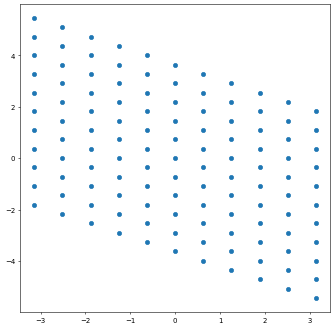

In [ ]:
def momentum_grid_kagome(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-0.5, 0.5, N)
        points2 = np.linspace(-0.5, 0.5, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def momentum_grid(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1,0])
        b2 = 2*np.pi * np.array([0, 1])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-0.5, 0.5, N)
        points2 = np.linspace(-0.5, 0.5, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals


#plot the scatter of the kx, ky points that have to be run over
total_K, kx_vals, ky_vals = momentum_grid_kagome(11)
plt.scatter(kx_vals, ky_vals)


In [ ]:
total_K, kx_vals, ky_vals = momentum_grid_kagome(11)

structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
S2_spin = np.zeros(len(total_K))

test_array = np.ones(len(final_qubit_dictionary))
fm_to_disorder = 0.0 
#this controls the simulation of a disordered array (1.0)
#or a purely FM one (0.0)
for i in range(len(test_array)):
    if np.random.rand() < fm_to_disorder:
        test_array[i] = 2*np.random.randint(2) - 1

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
dict_response = {}
for i in range(len(final_qubit_dictionary)):
    dict_response.update({test_response_qubits[i]:test_array[i]})

for kp in range(len(total_K)):
    val = 0
    for q1 in test_response_qubits:
        for q2 in test_response_qubits:
            kpoint = total_K[kp]
            r1 = final_qubit_dictionary[q1]
            r2 = final_qubit_dictionary[q2]
            rdist = r1 - r2
            val += np.exp(1j*np.dot(kpoint, rdist))*dict_response[q1]*dict_response[q2]
    val = val/len(test_response_qubits)
    structure_factor[kp] = val
    S2_spin[kp] = abs(val)



Text(0, 0.5, '$K_y$')

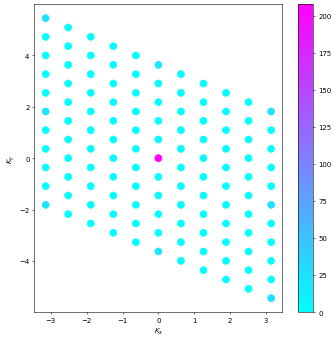

In [ ]:
norm = plt.Normalize(0,len(test_response_qubits))
cmap = plt.cm.get_cmap('cool')
plt.scatter(kx_vals, ky_vals, s=100, c=S2_spin, cmap=cmap, norm=norm)
plt.colorbar()
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')